In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.3 MB/s eta 0:00:00


In [ ]:
#importing all the essential libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import re #for data pre-processing
import unicodedata #library for data pre-processing
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
#mounting drive to collab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading file from drive
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/instagram.csv')

In [ ]:
df.head()

,review_description,rating,review_date
0,"The app is good for connecting with friends, f...",3,2023-07-11 23:57:07
1,"Used to be my favorite social media app, but ""...",2,2023-07-22 21:37:09
2,Instagram is the best of all the social media....,5,2023-07-25 03:24:58
3,"I love this app.. but as of late, I have been ...",2,2023-07-09 04:49:57
4,Used to be a great app but there are so many m...,3,2023-07-17 16:47:04


In [ ]:
df['rating'] = df['rating'].apply(lambda x: 1 if x > 3 else (0 if x < 3 else x))

In [ ]:
df.head()

,review_description,rating,review_date
0,"The app is good for connecting with friends, f...",3,2023-07-11 23:57:07
1,"Used to be my favorite social media app, but ""...",0,2023-07-22 21:37:09
2,Instagram is the best of all the social media....,1,2023-07-25 03:24:58
3,"I love this app.. but as of late, I have been ...",0,2023-07-09 04:49:57
4,Used to be a great app but there are so many m...,3,2023-07-17 16:47:04


In [ ]:
# Geting unique values in the "Sentiment" column
unique_values = df['rating'].unique()

print(unique_values)


[3 0 1]


In [ ]:
#checking for any null values
df['rating'].value_counts()

0    120550
1     63460
3     26532
Name: rating, dtype: int64

In [ ]:
Sentiment_0 = df[df['rating'] == 0]
Sentiment_1 = df[df['rating'] == 1]

#Selecting Equal no of Positive and Negative Reviews
num_samples = 25000
sample_df = pd.concat([Sentiment_0.sample(n=num_samples, random_state=42),
                        Sentiment_1.sample(n=num_samples, random_state=42)])

# Shuffling the sampled DataFrame
df = sample_df.sample(frac=1, random_state=42)

df.head()

,review_description,rating,review_date
163899,The best ever app inverted,1,2023-07-26 09:20:00
24737,I use it on a daily basis and it's the only pl...,0,2022-07-15 20:01:54
123022,"DO NOT DOWNLOAD. If you connect to the wifi, i...",0,2023-03-25 00:20:16
163317,Doesn't fully load when opened. Must open and ...,0,2019-01-20 00:47:22
60708,Its such a cool app because i get chat with my...,1,2023-03-30 05:22:03


In [ ]:
df['rating'].value_counts()

1    25000
0    25000
Name: rating, dtype: int64

In [ ]:
#Assigning X & y with review and sentiment respectively

X = df['review_description']
y = df['rating']

In [ ]:
#splitting values in to train, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7,stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.57, random_state=42)

In [ ]:
#chceking the length of the train, validation and test sets

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 15000
Test set size: 19950
Validation set size: 15050


In [ ]:
#seeing the index locations for the variables

print(X_train.index)
print(X_test.index)
print(X_val.index)

Int64Index([167086, 208038,  73605, 185533,  86507,   1981,  70463, 177320,
            163643, 186525,
            ...
             96675,  64352, 112981, 151710,  48248,  11590,  66954, 198628,
             42977, 141143],
           dtype='int64', length=15000)
Int64Index([ 21176, 159220, 109673,   5779, 209331, 173612, 142774,  26098,
             43149,  84386,
            ...
             94719, 161848,  16797,  94959, 140434,  31445, 177977,  60995,
             68905, 118582],
           dtype='int64', length=19950)
Int64Index([121642, 120369,  14567,  56214, 194715,  10931,  61174, 130277,
            151630,  17152,
            ...
            131717,  48845,  58481, 182171, 141207, 163631, 210286, 132698,
            208344, 143460],
           dtype='int64', length=15050)


In [ ]:
#resetting the index locations

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

In [ ]:
# Verifying the updated index values

print(X_train.index)
print(X_test.index)
print(X_val.index)

RangeIndex(start=0, stop=15000, step=1)
RangeIndex(start=0, stop=19950, step=1)
RangeIndex(start=0, stop=15050, step=1)


In [ ]:
#Printing the data brfore pre processing

print(X_train[0])
print(X_test[0])
print(X_val[0])

Awesome aap and I like this app very much ❤️❤️❤️❤️❤️❤️❤️
Instagram is best platform for comparison to all online platforms. This so owsome. I like it very much
Restricted my account unnecesaarily i want my id back . Since 1 hour i am trying to login but no security codes has been sent . I want my problem to be resolved today itself .


In [ ]:
#seeing the index locations for the variables

print(y_train.index)
print(y_test.index)
print(y_val.index)

Int64Index([167086, 208038,  73605, 185533,  86507,   1981,  70463, 177320,
            163643, 186525,
            ...
             96675,  64352, 112981, 151710,  48248,  11590,  66954, 198628,
             42977, 141143],
           dtype='int64', length=15000)
Int64Index([ 21176, 159220, 109673,   5779, 209331, 173612, 142774,  26098,
             43149,  84386,
            ...
             94719, 161848,  16797,  94959, 140434,  31445, 177977,  60995,
             68905, 118582],
           dtype='int64', length=19950)
Int64Index([121642, 120369,  14567,  56214, 194715,  10931,  61174, 130277,
            151630,  17152,
            ...
            131717,  48845,  58481, 182171, 141207, 163631, 210286, 132698,
            208344, 143460],
           dtype='int64', length=15050)


In [ ]:
#resetting the index locations

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [ ]:
print(y_train.index)
print(y_test.index)
print(y_val.index)

RangeIndex(start=0, stop=15000, step=1)
RangeIndex(start=0, stop=19950, step=1)
RangeIndex(start=0, stop=15050, step=1)


In [ ]:
print(y_train[0])
print(y_test[0])
print(y_val[0])

1
1
0


In [ ]:
def preprocess_text(text):
    # Removing HTML tags
    text = re.sub('<.*?>', '', text)

    # Removing accented characters by normalizing to ASCII
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Replacing patterns like n't, nt, and n t with not
    text = re.sub(r"\b(n['’]?t|n\s?t)\b", ' not', text)

    # Removing special characters
    text = re.sub("[^a-zA-Z0-9,'!]", ' ', text)

    # Converting text to lowercase
    text = text.lower()

    # Separating text into sentences based on punctuations and then removing punctuations
    sentences = re.split(r'[.!?]', text)
    sentences = [re.sub('[,]', '', sentence) for sentence in sentences]

    # Removing extra spaces
    text = ' '.join(' '.join(sentence.split()) for sentence in sentences)

    return text

In [ ]:
# Preprocessing the data

X_train_preprocessed = [preprocess_text(text) for text in X_train]

X_test_preprocessed = [preprocess_text(text) for text in X_test]

X_val_preprocessed = [preprocess_text(text) for text in X_val]


In [ ]:
#Printing pre processed data

print(X_train_preprocessed[0])
print(X_test_preprocessed[0])
print(X_val_preprocessed[0])

awesome aap and i like this app very much
instagram is best platform for comparison to all online platforms this so owsome i like it very much
restricted my account unnecesaarily i want my id back since 1 hour i am trying to login but no security codes has been sent i want my problem to be resolved today itself


Tokenizing and creating datasets for train, validation and test sets so they can be used through out different types of training sessions and evaluation of diferent models

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenizing and encoding the train data
X_train_encoded = tokenizer.batch_encode_plus(
    X_train_preprocessed,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)
# Tokenizing and encoding the validation data
X_val_encoded = tokenizer.batch_encode_plus(
    X_val_preprocessed,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

In [ ]:
# Extracting input tensors from the encoded data
input_ids_train = X_train_encoded['input_ids']
attention_masks_train = X_train_encoded['attention_mask']
labels_train = torch.tensor(y_train.values)

input_ids_val = X_val_encoded['input_ids']
attention_masks_val = X_val_encoded['attention_mask']
labels_val = torch.tensor(y_val.values)

# Creating datasets
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
# Tokenizing and encoding the test data
X_test_encoded = tokenizer.batch_encode_plus(
    X_test_preprocessed,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

In [ ]:
# Extracting input tensors and attention masks from the encoded data

input_ids_test = X_test_encoded['input_ids']
attention_masks_test = X_test_encoded['attention_mask']
labels_test = torch.tensor(y_test.values)

# Creating datasets
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
# Setting the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. SGD Optimizer

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# declaring Hyperparameters
batch_size = 64
early_stopping_patience = 3
epochs_without_improvement = 0
num_cpu = 12
num_epochs = 5
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = optim.SGD(model.parameters(), lr= 2e-5, momentum=0.9)

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks,labels = labels)

        loss = outputs.loss

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGDInstagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.6970995181083679, Validation Accuracy: 0.5811960132890366
Epoch 2/5, Loss: 0.6755001706123352, Validation Accuracy: 0.6532225913621262
Epoch 3/5, Loss: 0.6364153370221456, Validation Accuracy: 0.6691029900332226
Epoch 4/5, Loss: 0.5508789223035176, Validation Accuracy: 0.7631893687707642
Epoch 5/5, Loss: 0.4622252299149831, Validation Accuracy: 0.7994684385382059


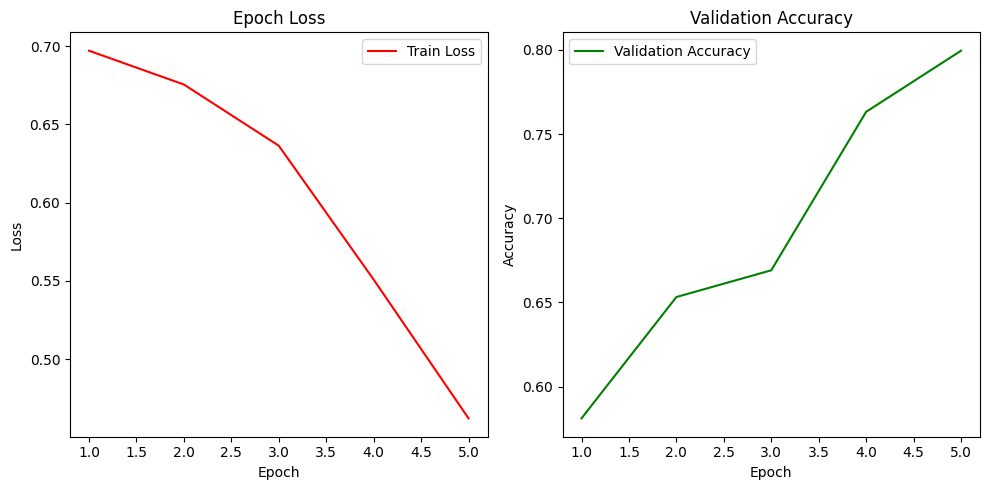

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBSGDInstagram_plot.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGDInstagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 80.16%
Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.77      0.80     10012
    positive       0.78      0.83      0.81      9938

    accuracy                           0.80     19950
   macro avg       0.80      0.80      0.80     19950
weighted avg       0.80      0.80      0.80     19950

Confusion Matrix:
 [[7704 2308]
 [1651 8287]]


# 2 SGD Optimizer with RLrOnPlateu LR Scheduler




In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# declaring Hyperparameters
batch_size = 64
early_stopping_patience = 3
epochs_without_improvement = 0
num_cpu = 12
num_epochs = 5
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = optim.SGD(model.parameters(), lr= 2e-5, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels = labels)

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    scheduler.step(epoch_loss)


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGD1Instagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.6956403835614522, Validation Accuracy: 0.5740199335548173
Epoch 2/5, Loss: 0.670462198193868, Validation Accuracy: 0.6474418604651163
Epoch 3/5, Loss: 0.6346898015658061, Validation Accuracy: 0.7077076411960133
Epoch 4/5, Loss: 0.5712994891484579, Validation Accuracy: 0.7757475083056479
Epoch 5/5, Loss: 0.48668092335065205, Validation Accuracy: 0.8167441860465117


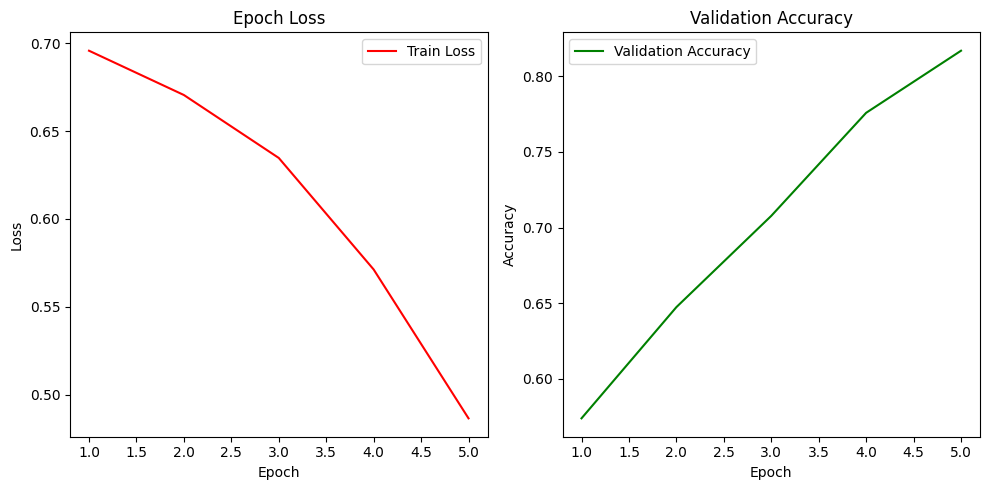

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBSGD1Instagram_plot.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGD1Instagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 82.24%
Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.90      0.84     10012
    positive       0.88      0.75      0.81      9938

    accuracy                           0.82     19950
   macro avg       0.83      0.82      0.82     19950
weighted avg       0.83      0.82      0.82     19950

Confusion Matrix:
 [[8989 1023]
 [2520 7418]]


# 3 SGD Optimizer with Cosineannealing LR Scheduler




In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# declaring Hyperparameters
batch_size = 64
early_stopping_patience = 3
epochs_without_improvement = 0
num_cpu = 12
num_epochs = 5
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = optim.SGD(model.parameters(), lr= 2e-5, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels = labels)

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    scheduler.step()


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGD2Instagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.6965387877146403, Validation Accuracy: 0.6249169435215947
Epoch 2/5, Loss: 0.6834427138328553, Validation Accuracy: 0.6085049833887043
Epoch 3/5, Loss: 0.6740490446726481, Validation Accuracy: 0.7158139534883721
Epoch 4/5, Loss: 0.6640699397087098, Validation Accuracy: 0.7119601328903654
Epoch 5/5, Loss: 0.6576073386192322, Validation Accuracy: 0.7143521594684386


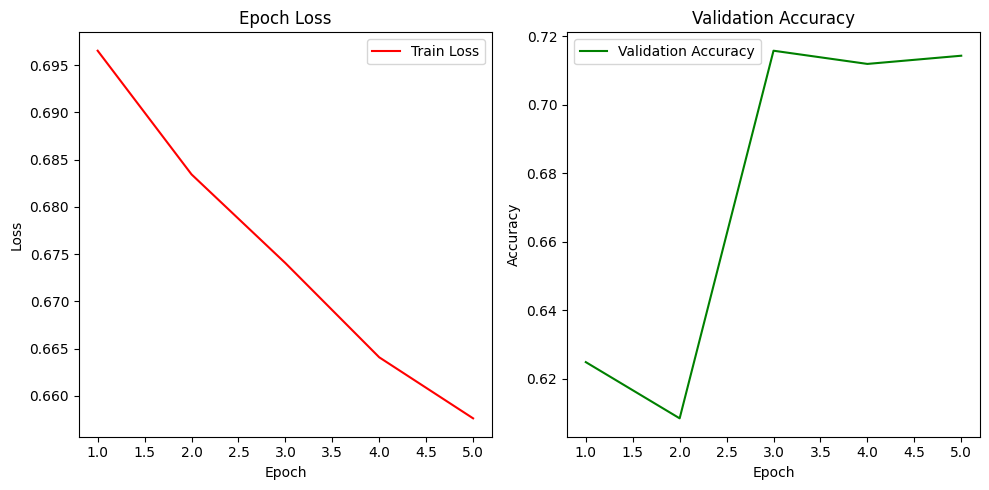

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBSGD2Instagram_plot.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGD2Instagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 71.59%
Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.68      0.71     10012
    positive       0.70      0.75      0.73      9938

    accuracy                           0.72     19950
   macro avg       0.72      0.72      0.72     19950
weighted avg       0.72      0.72      0.72     19950

Confusion Matrix:
 [[6809 3203]
 [2465 7473]]


# 4 SGD Optimizer with Exponential LR Scheduler




In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# declaring Hyperparameters
batch_size = 64
early_stopping_patience = 3
epochs_without_improvement = 0
num_cpu = 12
num_epochs = 5
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = optim.SGD(model.parameters(), lr= 2e-5, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.95)

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels = labels)

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    scheduler.step()


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGD3Instagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.6976233206113179, Validation Accuracy: 0.5766777408637874
Epoch 2/5, Loss: 0.6666155264218648, Validation Accuracy: 0.6409302325581395
Epoch 3/5, Loss: 0.6085423913637797, Validation Accuracy: 0.7178073089700997
Epoch 4/5, Loss: 0.5297040884812673, Validation Accuracy: 0.7708305647840532
Epoch 5/5, Loss: 0.4658008702596029, Validation Accuracy: 0.7912956810631229


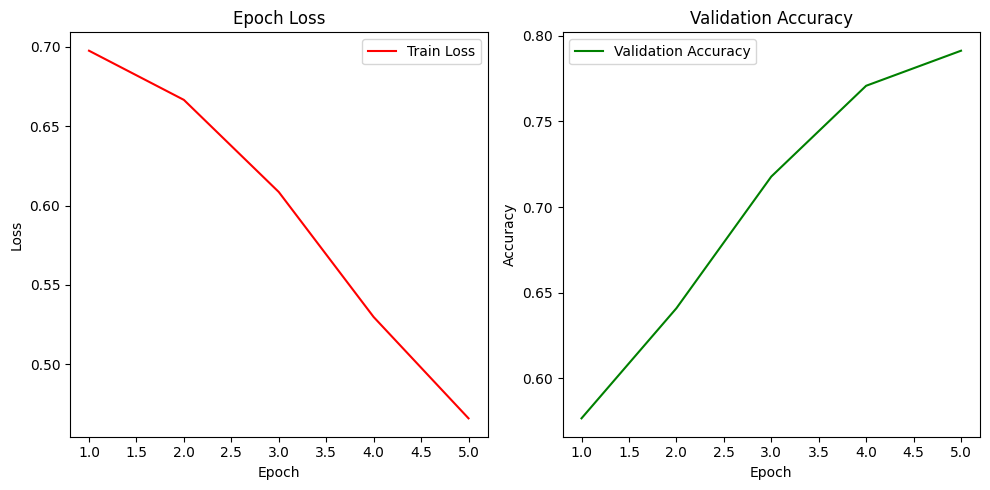

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBSGD3Instagram_plot.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGD3Instagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 79.18%
Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.75      0.78     10012
    positive       0.77      0.83      0.80      9938

    accuracy                           0.79     19950
   macro avg       0.79      0.79      0.79     19950
weighted avg       0.79      0.79      0.79     19950

Confusion Matrix:
 [[7518 2494]
 [1659 8279]]


# 5 SGD Optimizer with Cyclic LR Scheduler




In [ ]:
from torch.optim.lr_scheduler import CyclicLR

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# declaring Hyperparameters
batch_size = 64
early_stopping_patience = 3
epochs_without_improvement = 0
num_cpu = 12
num_epochs = 5
best_accuracy = 0.0
train_losses = []
val_accuracies = []
train_losses.clear()
val_accuracies.clear()

# optimizer
optimizer = optim.SGD(model.parameters(), lr= 2e-5, momentum=0.9)
scheduler = CyclicLR(optimizer, base_lr=1e-6, max_lr=2e-5, step_size_up=2000, mode='triangular')

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

for epoch in range(num_epochs):
    running_loss = 0.0

    # Training
    model.train()
    for inputs, attention_masks, labels in train_dataloader:
        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels = labels)

        loss = outputs.loss

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    scheduler.step()


   # Validation
    model.eval()  # Setting model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Get model's predictions
            outputs = model(inputs, attention_mask=attention_masks)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    val_accuracies.append(accuracy)


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Printing the loss and accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Validation Accuracy: {accuracy}")

# Saving the trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGD4Instagram.pt"
torch.save(best_model_state, BERT_Tuned_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.7097687003135681, Validation Accuracy: 0.49754152823920267
Epoch 2/5, Loss: 0.6995918028195699, Validation Accuracy: 0.4977408637873754
Epoch 3/5, Loss: 0.694918863773346, Validation Accuracy: 0.506578073089701
Epoch 4/5, Loss: 0.6908404262860616, Validation Accuracy: 0.5415282392026578
Epoch 5/5, Loss: 0.6886426423072814, Validation Accuracy: 0.5807973421926911


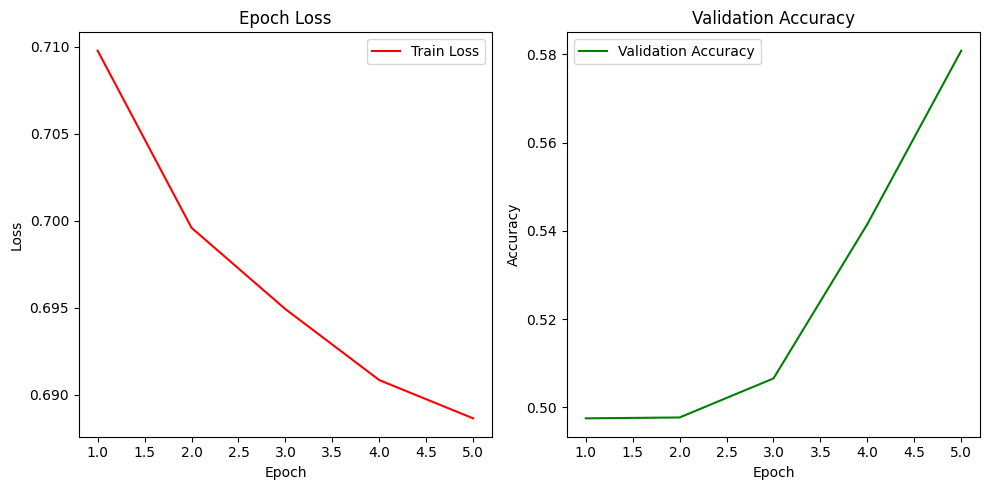

In [ ]:
# Plotting epoch loss and validation accuracy graphs
num_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

save_path = "/content/drive/MyDrive/Colab Notebooks/BBSGD4Instagram_plot.png"
plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [ ]:
# Loading trained model
BERT_Tuned_file = "/content/drive/MyDrive/Colab Notebooks/BBSGD4Instagram.pt"
model.load_state_dict(torch.load(BERT_Tuned_file))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)

# Creating dataloaders for test
batch_size = 64
num_cpu = 12

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_cpu, pin_memory=True, shuffle=False)

# Evaluating the model on the test set
all_preds = []
all_labels = []

all_preds.clear()
all_labels.clear()

with torch.no_grad():
        for inputs, attention_masks, labels in test_dataloader:
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

class_names = ["negative", "positive"]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 58.78%
Classification Report:
               precision    recall  f1-score   support

    negative       0.56      0.89      0.68     10012
    positive       0.72      0.29      0.41      9938

    accuracy                           0.59     19950
   macro avg       0.64      0.59      0.55     19950
weighted avg       0.64      0.59      0.55     19950

Confusion Matrix:
 [[8880 1132]
 [7091 2847]]


In [ ]:
user_input = input("Enter a sentence: ")
preprocessed_input = preprocess_text(user_input)
encoded_input= tokenizer.batch_encode_plus(
    [preprocessed_input],
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)
input_ids = encoded_input['input_ids'].to(device)
attention_masks_test = encoded_input['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks_test)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

class_names = ["negative", "positive"]
predicted_sentiment = class_names[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

Enter a sentence: good bad movie
Predicted sentiment: negative
